## Importacion liberias

In [131]:
import torch.nn as nn
import torch
#from torch.utils.data import Dataset, DataLoader
import os
import sys
import json
import numpy as np
import pandas as pd
import datasets as ds
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, EarlyStoppingCallback
)
from transformers.integrations import TensorBoardCallback
from transformers import EvalPrediction
from sklearn.metrics import f1_score, recall_score, precision_score
from torcheval.metrics import MulticlassAccuracy
from typing import Dict, List, Tuple
from datasets import DatasetDict, load_dataset
sys.path.append(os.path.abspath('./code'))
from visualization import Eda
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding

In [132]:
import sys
print(sys.executable)

c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Scripts\python.exe


## Versiones, sys info, device ...

In [133]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(torch.cuda.get_arch_list())

# sys, library info
print("Operating System:", os.name)
print("Platform:", sys.platform)
print("Current Working Directory:", os.getcwd())
print("Environment Variables:", os.environ)
print("Python Version:", sys.version)
print("Command-line arguments:", sys.argv)
print(ds.__version__)

PyTorch version: 2.3.0+cu118
CUDA available: True
CUDA version: 11.8
Device name: NVIDIA RTX A500 Laptop GPU
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
Operating System: nt
Platform: win32
Current Working Directory: c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo
Environment Variables: environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\Jorge\\AppData\\Roaming', 'APPLICATION_INSIGHTS_NO_DIAGNOSTIC_CHANNEL': '1', 'BRB': 'C:\\Program Files\\HP\\Sure Click\\bin', 'BRS': 'C:\\Program Files\\HP\\Sure Click\\servers', 'CHROME_CRASHPAD_PIPE_NAME': '\\\\.\\pipe\\crashpad_3560_AIMNTGMCJFMSTMDG', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'KOKE00', 'COMSPEC': 'C:\\windows\\system32\\cmd.exe', 'CUDA_PATH': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.5', 'CUDA_PA

In [135]:
torch.cuda.empty_cache()

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **EDA**

In [137]:
df = pd.read_csv("./data/data_tw.csv")
df.drop(columns = 	'Unnamed: 0', inplace = True)

In [138]:
df.head()

,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [139]:
df["label"].value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

In [140]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label'],
      dtype='object')

In [141]:
df.shape

(20000, 10)

In [197]:
# fecha post
df["post_created"].value_counts()

post_created
Sun Jan 08 06:00:47 +0000 2017    6
Sat May 02 21:15:55 +0000 2015    5
Thu Apr 30 12:18:52 +0000 2015    5
Tue Apr 21 10:15:28 +0000 2015    4
Sat Dec 31 14:12:17 +0000 2016    4
                                 ..
Fri Aug 28 12:24:54 +0000 2009    1
Fri Aug 28 12:56:23 +0000 2009    1
Fri Aug 28 12:56:36 +0000 2009    1
Fri Aug 28 14:08:16 +0000 2009    1
Thu Jan 12 00:04:47 +0000 2017    1
Name: count, Length: 19102, dtype: int64

In [198]:
# fechas unicas existentes [ver si post dedlos tweets repiten en mismas fechas]
df["post_created"].nunique()

19102

In [199]:
proporcion_fechas_unicas = df["post_created"].value_counts() / df["post_created"].nunique()

In [200]:
proporcion_fechas_unicas

post_created
Sun Jan 08 06:00:47 +0000 2017    0.000314
Sat May 02 21:15:55 +0000 2015    0.000262
Thu Apr 30 12:18:52 +0000 2015    0.000262
Tue Apr 21 10:15:28 +0000 2015    0.000209
Sat Dec 31 14:12:17 +0000 2016    0.000209
                                    ...   
Fri Aug 28 12:24:54 +0000 2009    0.000052
Fri Aug 28 12:56:23 +0000 2009    0.000052
Fri Aug 28 12:56:36 +0000 2009    0.000052
Fri Aug 28 14:08:16 +0000 2009    0.000052
Thu Jan 12 00:04:47 +0000 2017    0.000052
Name: count, Length: 19102, dtype: float64

In [142]:
labels = df['label'].unique()

In [143]:
labels

array([1, 0], dtype=int64)

#### **Creacion de nuevas columnas de año,mes,dia,hora ... a apartir de fecha publicacion del post**

In [186]:
def extract_date_components(date_string):
    format_string = "%a %b %d %H:%M:%S %z %Y"
    dt = datetime.strptime(date_string, format_string)
    return pd.Series({
        'dia': dt.day,
        'mes': dt.month,
        'año': dt.year,
        'h': dt.hour,
        'min': dt.minute,
        'seg': dt.second,
        'dia_semana': dt.strftime("%A"),
        'nombre_mes': dt.strftime("%B")
    })
date_components_df = df['post_created'].apply(extract_date_components)
df = pd.concat([df, date_components_df], axis=1)

In [188]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes',
       'año', 'h', 'min', 'seg', 'dia_semana', 'nombre_mes'],
      dtype='object')

In [189]:
df.head()

,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label,dia,mes,año,h,min,seg,dia_semana,nombre_mes
0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1,30,8,2015,7,48,37,Sunday,August
1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1,30,8,2015,7,31,33,Sunday,August
2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1,29,8,2015,22,11,7,Saturday,August
3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1,29,8,2015,18,40,49,Saturday,August
4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1,29,8,2015,18,40,26,Saturday,August


In [190]:
tw_eda = Eda(data = df, auto_eda = False, target_var  = "label")

In [191]:
# Columnas categoricas del df
tw_eda.cat_cols

['post_created', 'post_text', 'dia_semana', 'nombre_mes']

In [195]:
proporcion_fechas_unicas

post_created
Sun Jan 08 06:00:47 +0000 2017    0.000314
Sat May 02 21:15:55 +0000 2015    0.000262
Thu Apr 30 12:18:52 +0000 2015    0.000262
Tue Apr 21 10:15:28 +0000 2015    0.000209
Sat Dec 31 14:12:17 +0000 2016    0.000209
                                    ...   
Fri Aug 28 12:24:54 +0000 2009    0.000052
Fri Aug 28 12:56:23 +0000 2009    0.000052
Fri Aug 28 12:56:36 +0000 2009    0.000052
Fri Aug 28 14:08:16 +0000 2009    0.000052
Thu Jan 12 00:04:47 +0000 2017    0.000052
Name: count, Length: 19102, dtype: float64

__________________________________________________________________
Numero de valores diferentes en la columna == post_id ---  19881
Tamaño de la columna == post_id ---  20000
% de valores unicos frente al numero de muestras de la columna == post_id ---  99.405 %
Media de la columna == post_id ---  6.874728440326501e+17
------------------------------------------------------------------
Maximo valor de la columna == post_id ---  819457358145273856
Informacion del maximo valor en la columna : post_id:
 post_id       819457358145273856
user_id                324294391
followers                     59
friends                      183
favourites                  2456
statuses                    6180
retweets                       0
label                          0
dia                           12
mes                            1
año                         2017
h                              8
min                           13
seg                           53
Name: 17379, dtype: int64
-------

,post_id,user_id,followers,friends,favourites,statuses,retweets,label,dia,mes,año,h,min,seg
COUNT,2.000000e+04,2.000000e+04,20000.00,20000.00,20000.00,20000.00,20000.00,20000.0,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
MIN,3.555966e+09,1.472438e+07,0.00,0.00,0.00,3.00,0.00,0.0,1.00,1.00,2009.00,0.00,0.00,0.00
25%,5.931686e+17,3.242944e+08,177.00,211.00,243.00,5129.00,0.00,0.0,8.00,1.00,2015.00,4.00,13.00,13.00
50%,7.637400e+17,1.052122e+09,476.00,561.00,2752.00,13251.00,0.00,0.5,17.00,8.00,2016.00,10.00,26.00,28.00
75%,8.153124e+17,2.285923e+09,1197.00,701.00,8229.00,52892.00,1.00,1.0,24.00,12.00,2016.00,17.00,42.00,42.00
MAX,8.194574e+17,7.631825e+17,28614.00,28514.00,39008.00,1063601.00,839540.00,1.0,31.00,12.00,2017.00,23.00,59.00,59.00
MEAN,6.874728e+17,3.548623e+16,900.48,782.43,6398.24,44394.42,1437.93,0.5,16.20,6.71,2015.49,10.86,27.22,28.34
STD,1.708396e+17,1.606083e+17,1899.91,1834.82,8393.07,140778.52,15119.67,0.5,9.22,4.74,1.49,7.17,17.21,16.99
NA,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
NA %,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


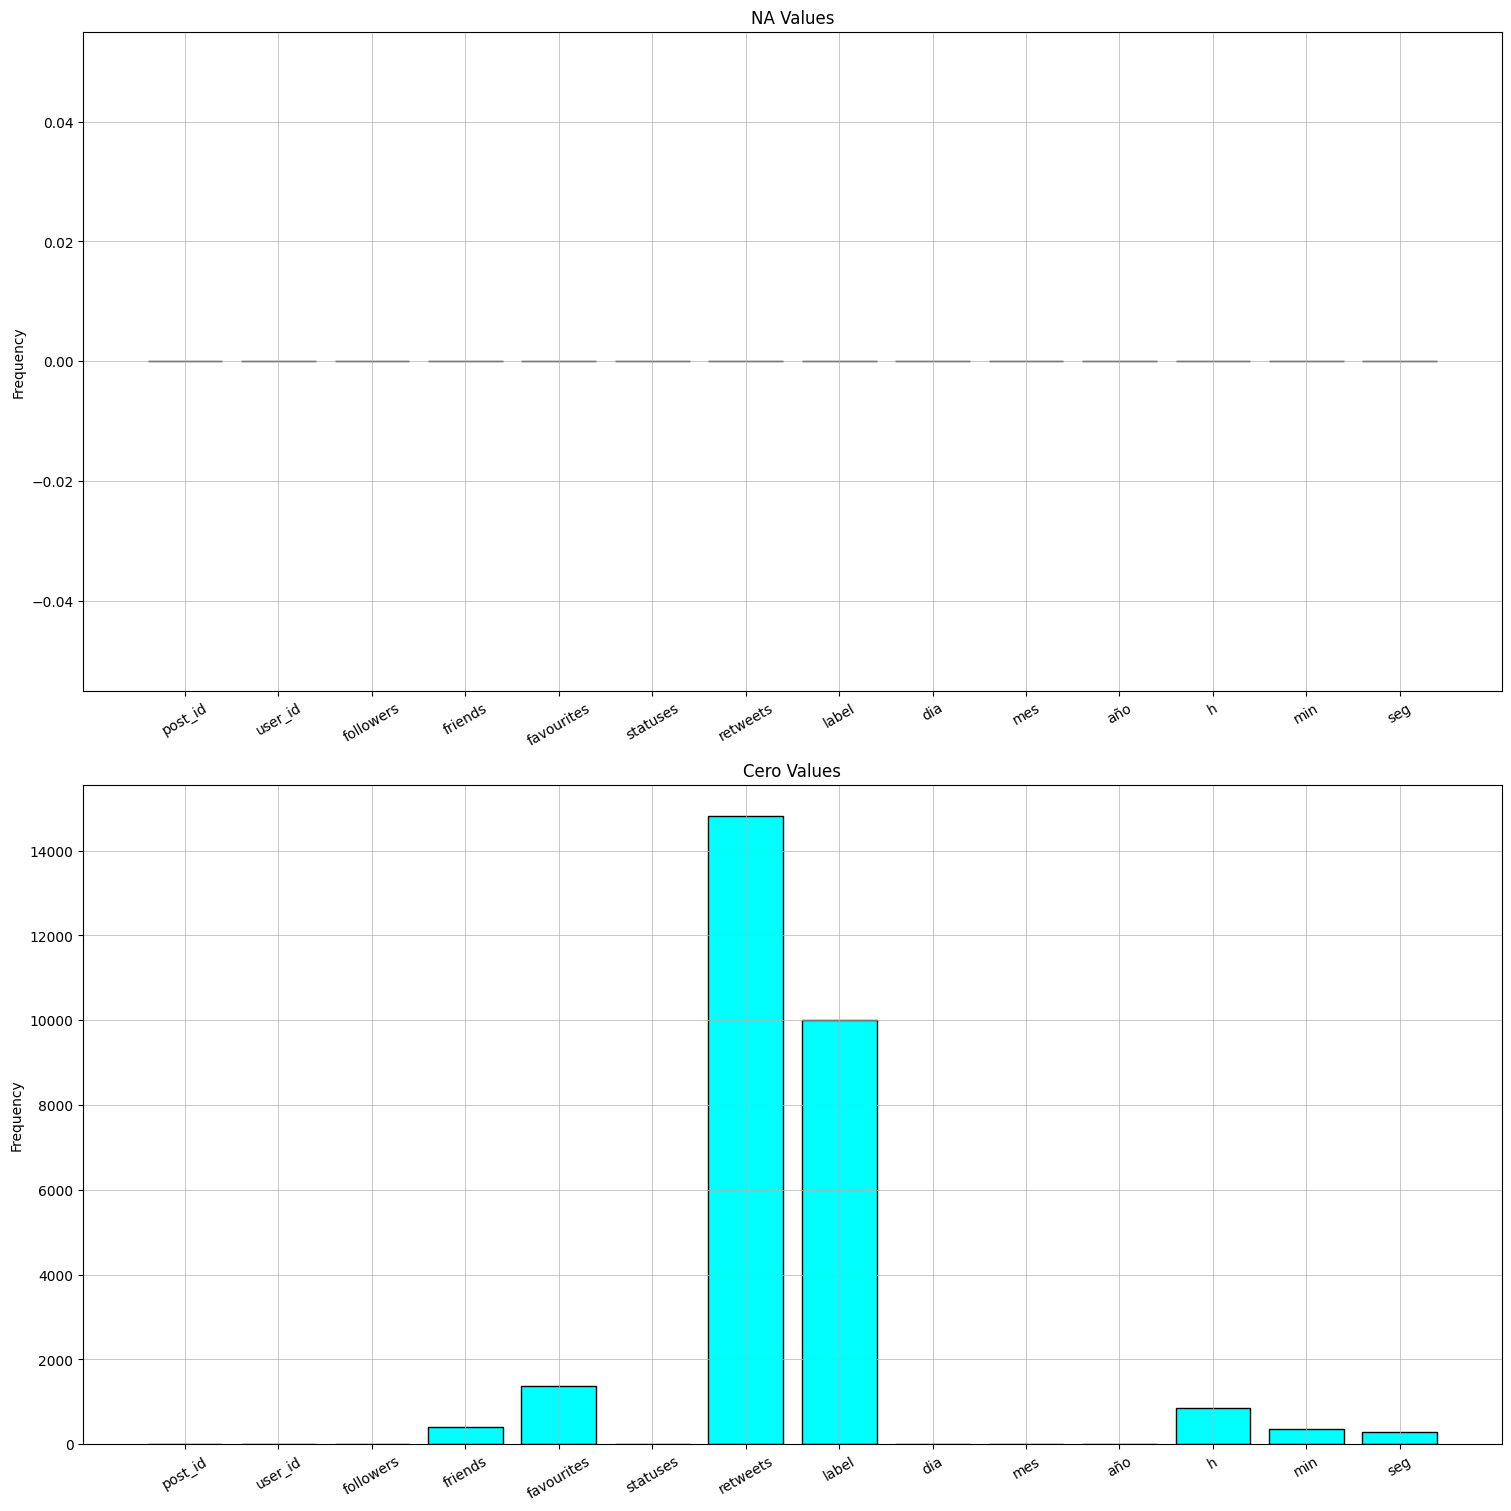

In [201]:
# Columnas numericas del df
tw_eda.infonum

####  **Antes de empezar con las graficas y debido a las diferentes escalas de las variables numericas se estandarizan estas y se dropean el user_id, label , el post_id ... para ue no se vean afectadas por la estandarizacion [resta la media y divide entre la varianza de cada feature por separado]**

In [202]:
num_data_clean = tw_eda.num_data.drop(columns = ["user_id","post_id",'label','año','mes','dia','h','min','seg'])

In [203]:
num_data_clean.columns

Index(['followers', 'friends', 'favourites', 'statuses', 'retweets'], dtype='object')

In [204]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std_data = std.fit_transform(num_data_clean)
std_dataframe = pd.DataFrame(data = std_data ,columns = num_data_clean.columns.tolist())
tw_eda_std = Eda(data = std_dataframe)

__________________________________________________________________
Numero de valores diferentes en la columna == followers ---  69
Tamaño de la columna == followers ---  20000
% de valores unicos frente al numero de muestras de la columna == followers ---  0.345 %
Media de la columna == followers ---  -0.0
------------------------------------------------------------------
Maximo valor de la columna == followers ---  14.587086299153158
Informacion del maximo valor en la columna : followers:
 followers     14.587086
friends       15.114450
favourites    -0.762342
statuses      -0.281381
retweets      -0.095039
Name: 2594, dtype: float64
------------------------------------------------------------------
Numero de valores nulos en la columna == followers ---   0
Numero de valores '0' en la columna == followers ---   0
Porcentaje de valores '0' en la columna == followers ---   0.0
__________________________________________________________________
____________________________________________

,followers,friends,favourites,statuses,retweets
COUNT,20000.00,20000.00,20000.00,20000.00,20000.00
MIN,-0.47,-0.43,-0.76,-0.32,-0.10
25%,-0.38,-0.31,-0.73,-0.28,-0.10
50%,-0.22,-0.12,-0.43,-0.22,-0.10
75%,0.16,-0.04,0.22,0.06,-0.10
MAX,14.59,15.11,3.89,7.24,55.43
MEAN,-0.00,-0.00,-0.00,0.00,0.00
STD,1.00,1.00,1.00,1.00,1.00
NA,0.00,0.00,0.00,0.00,0.00
NA %,0.00,0.00,0.00,0.00,0.00


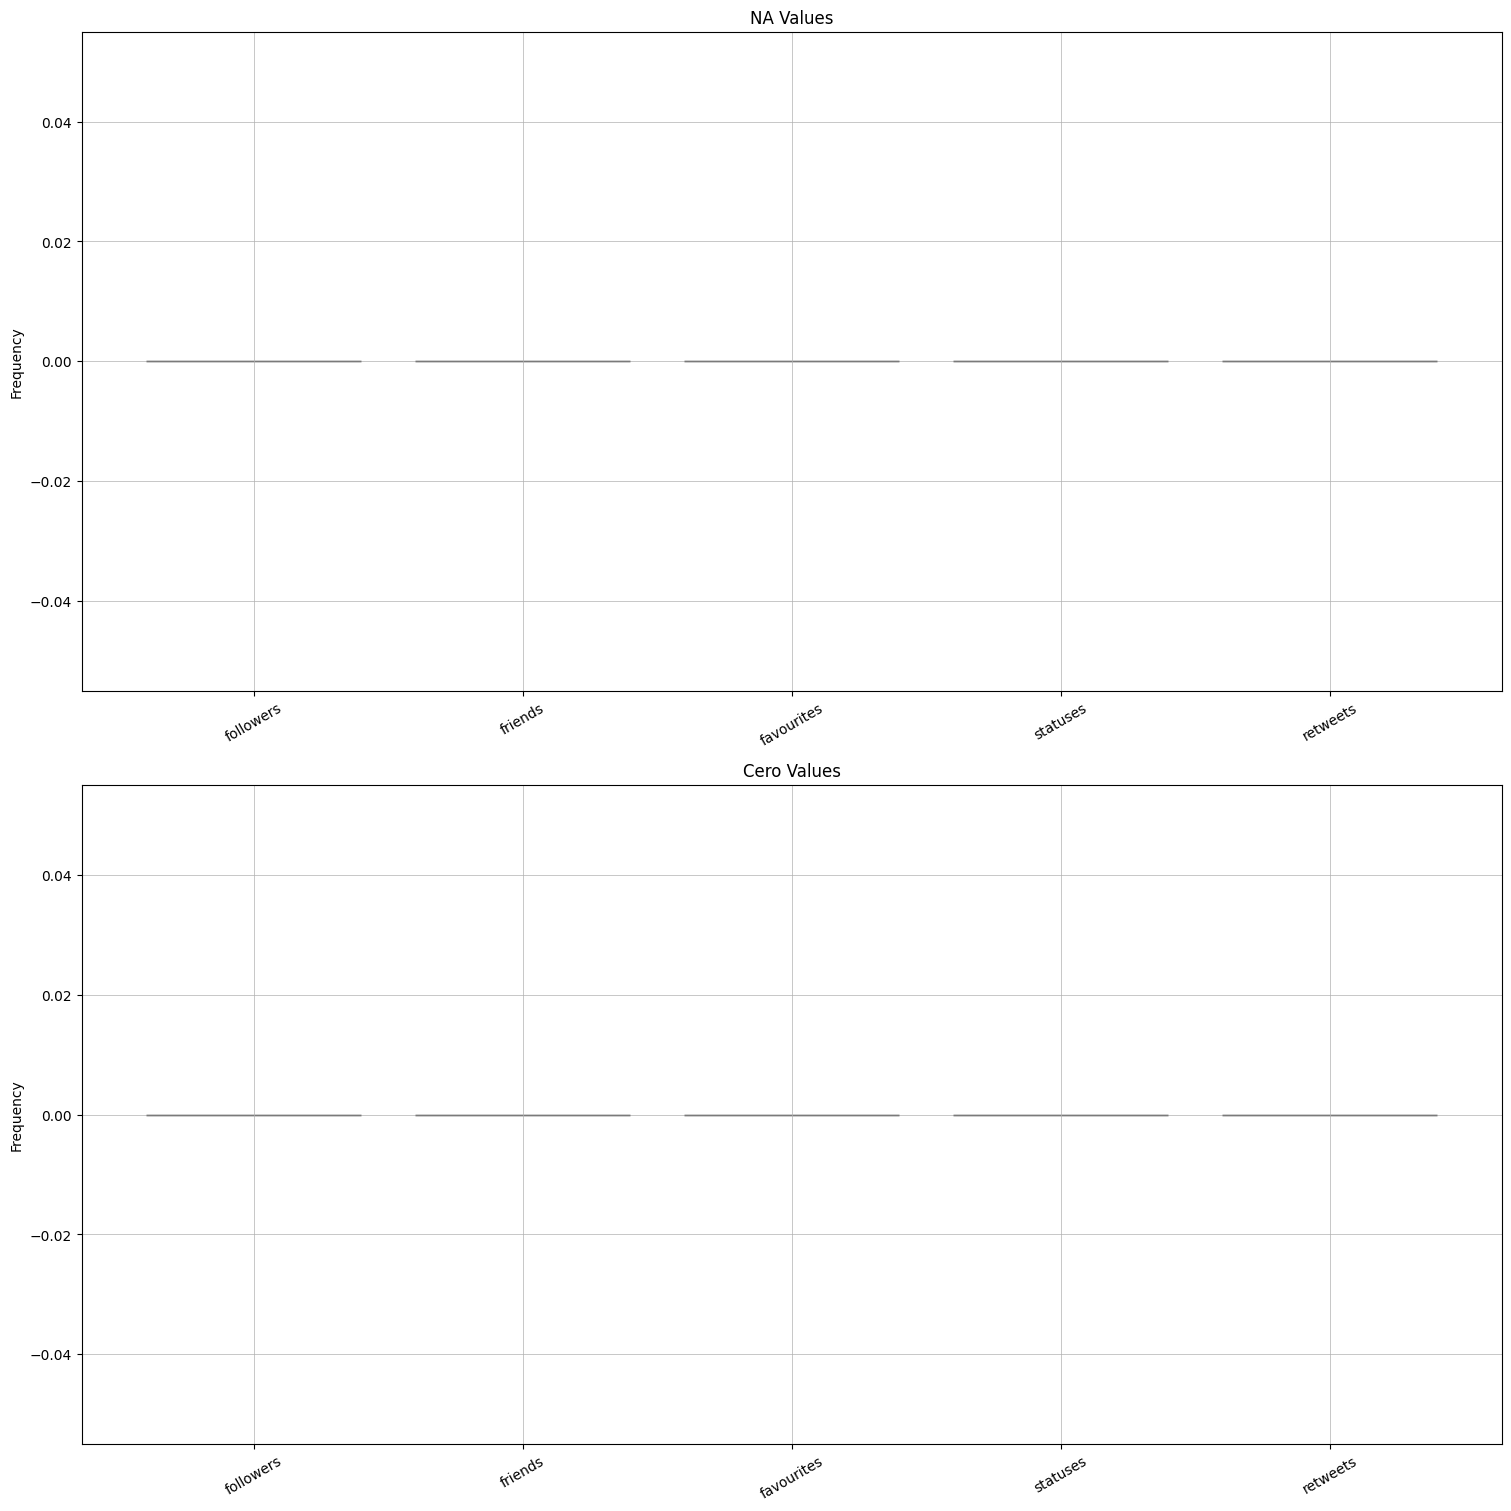

In [205]:
# Exploramos el cambio de escala aplicado
tw_eda_std.infonum

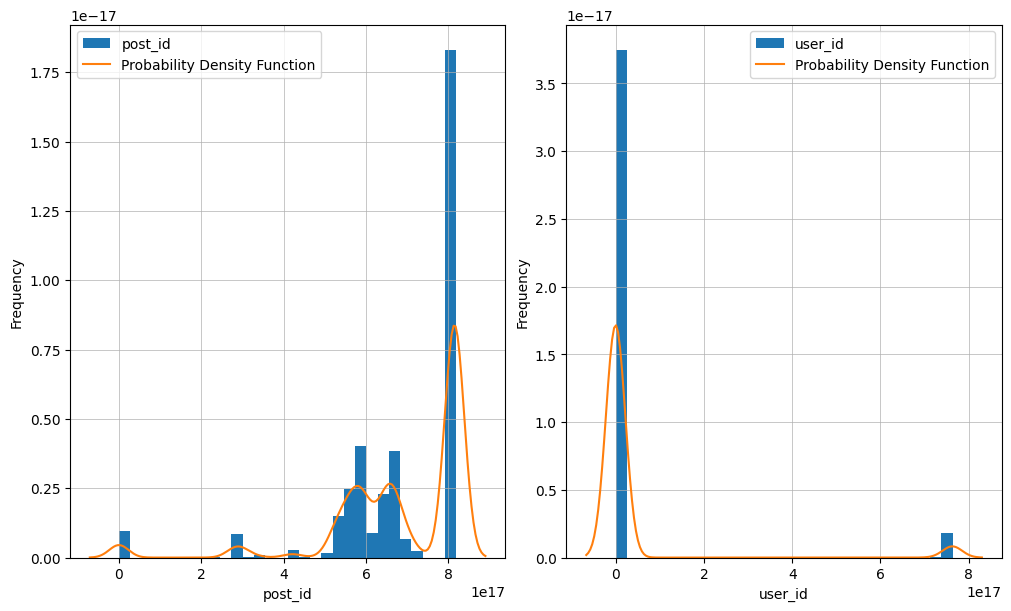

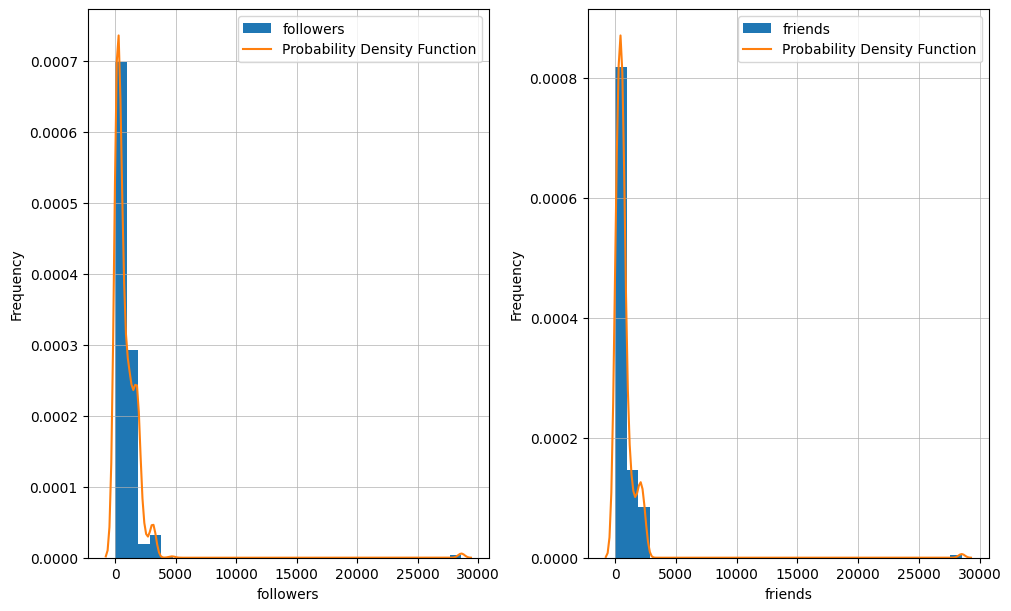

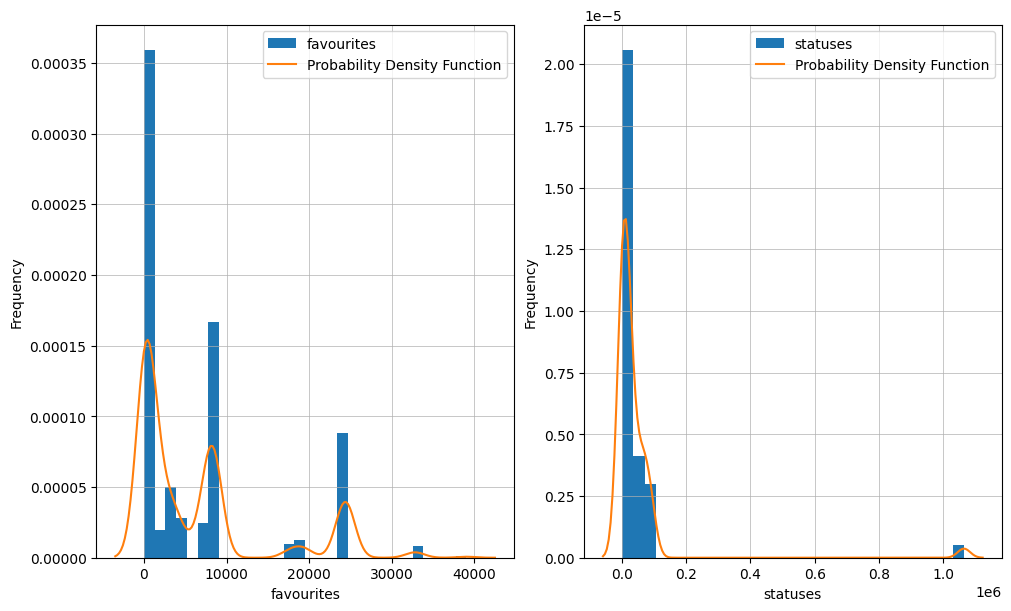

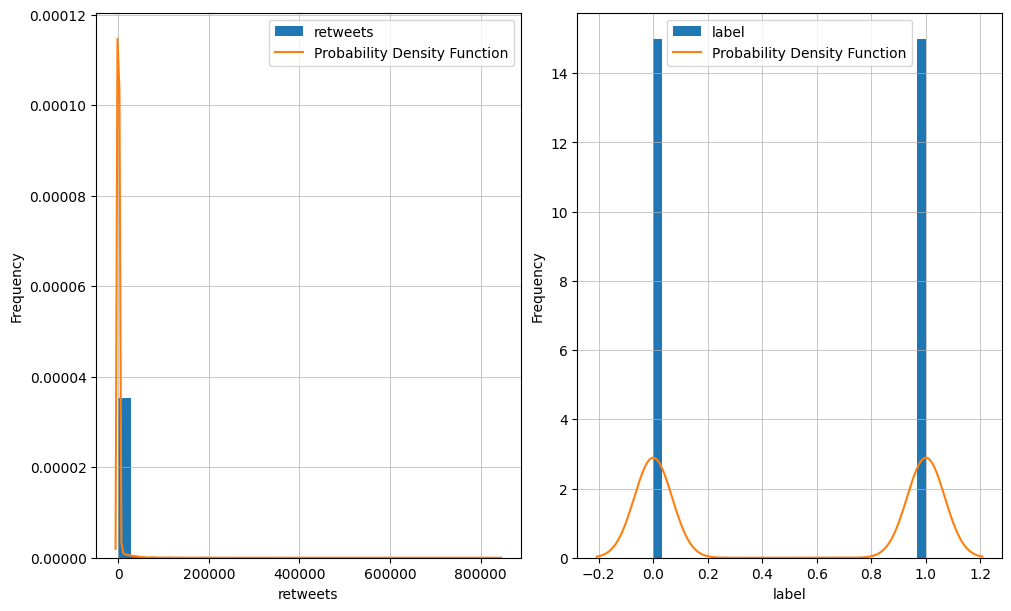

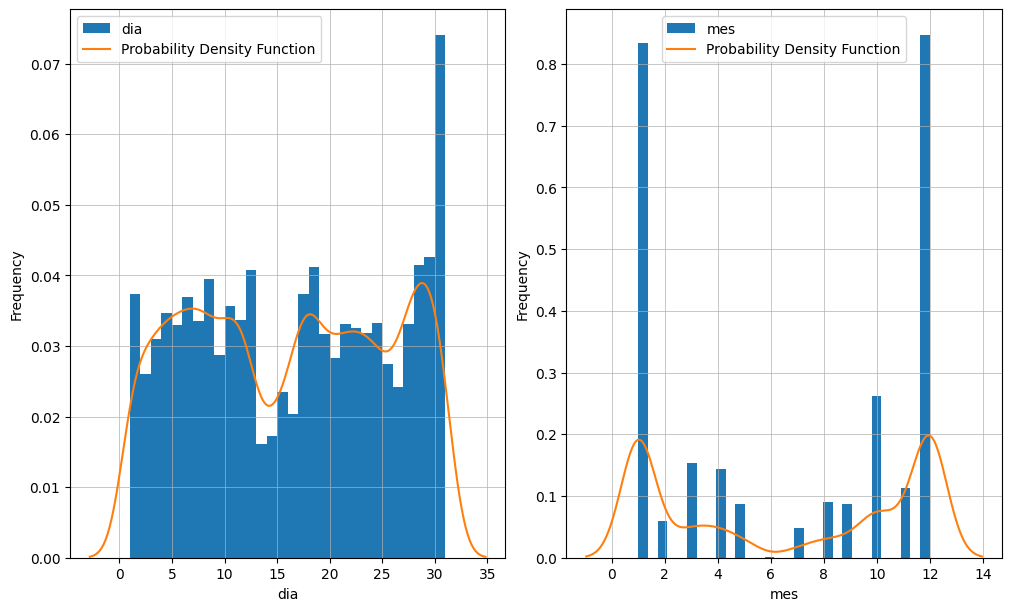

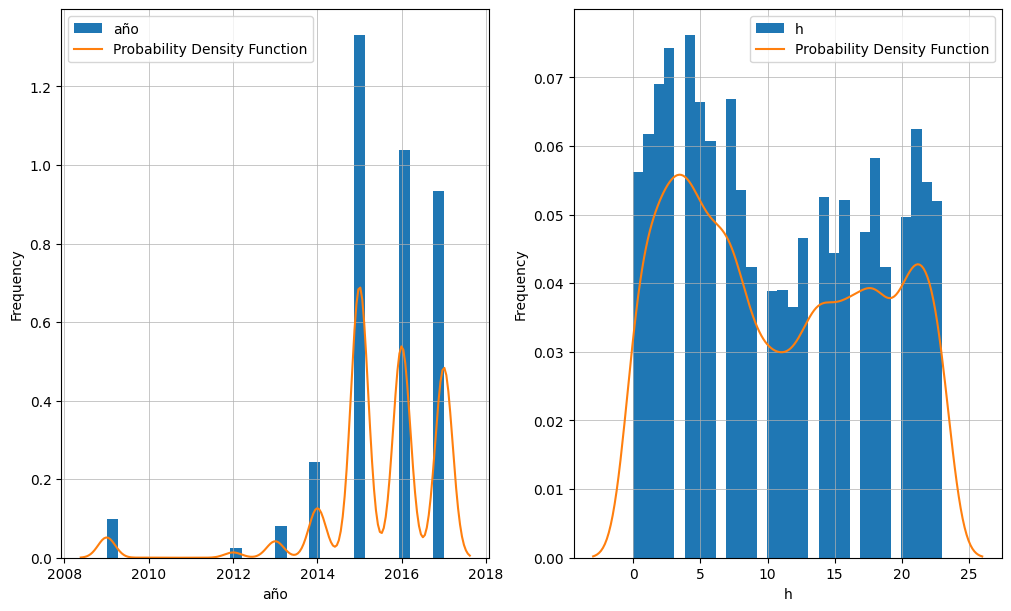

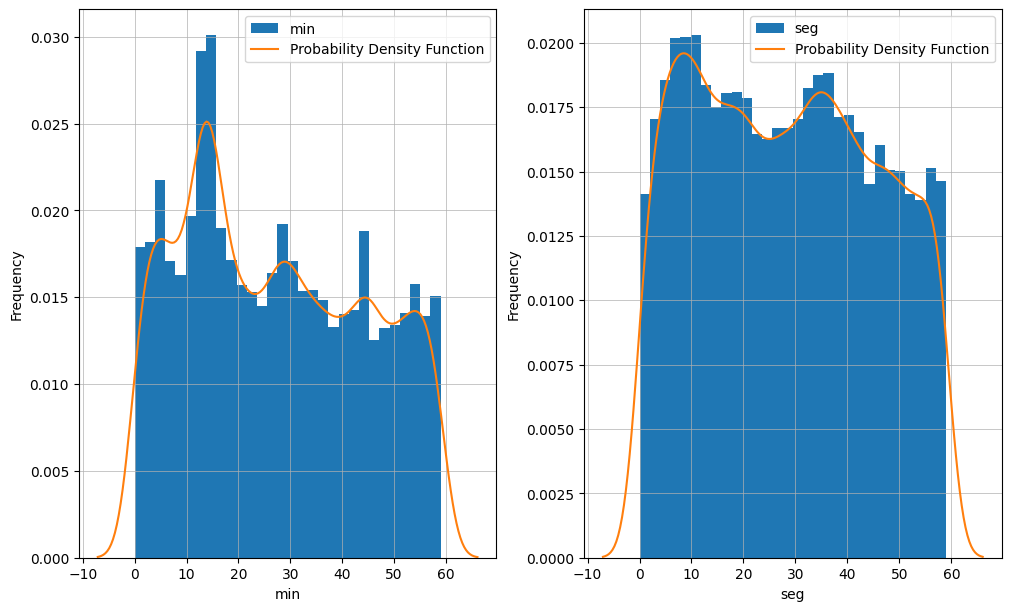

In [209]:
# Histogramas de las vraiables numericas
tw_eda.plot_hist(
                        bins = 30 ,
                        divide_feature = None,
                        layout = 'constrained',
                        fig_x_size = 10 ,
                        fig_y_size = 6,
                        fig_rows = 1 ,
                        fig_cols = 2 ,
                        linewidth = 0.5 ,
                        density = True,
                        stacked = True
                      )

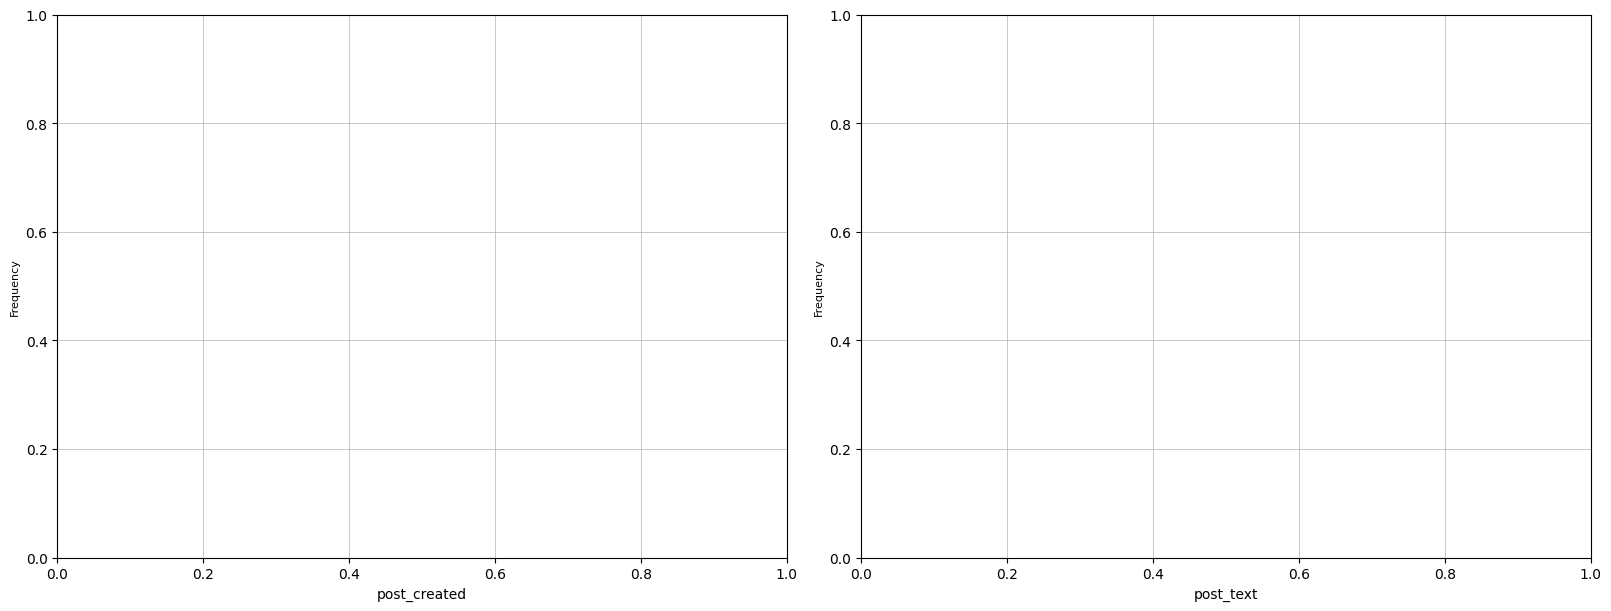

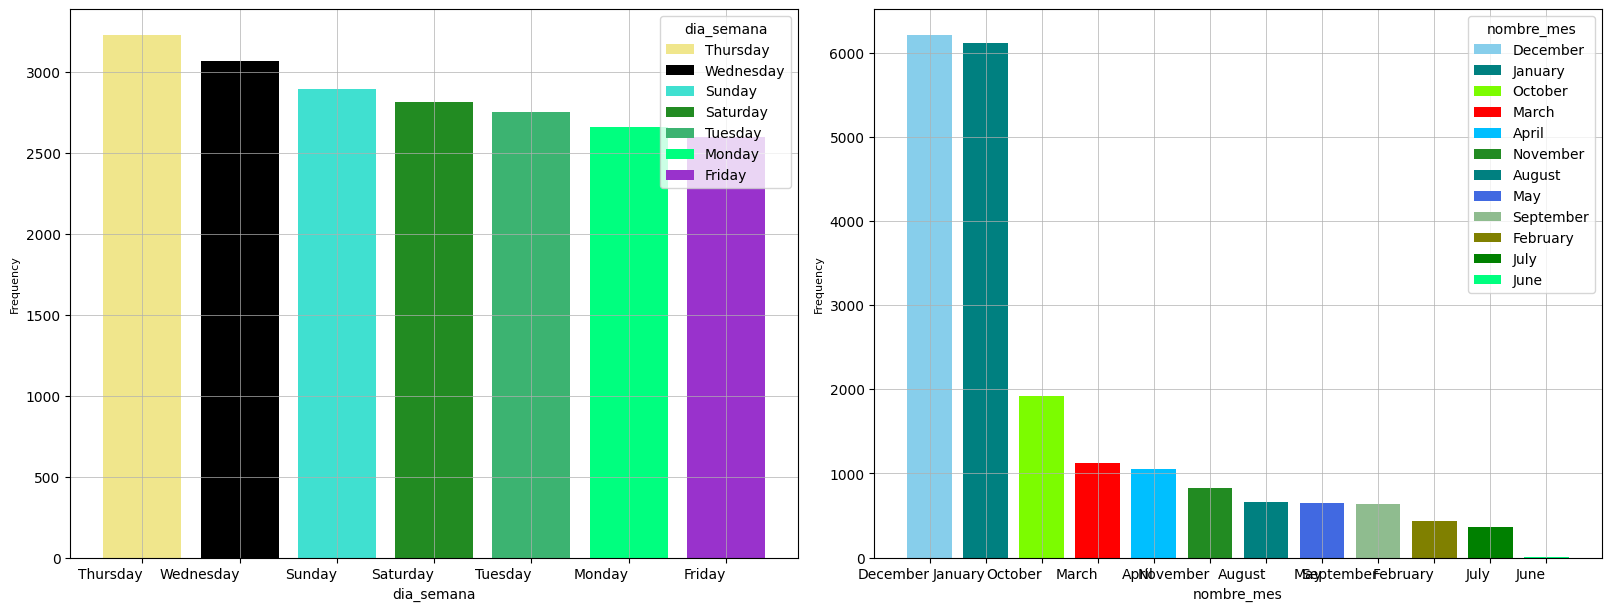

In [218]:
# Diagramas de barras 
tw_eda.plot_bar(
            layout = 'constrained',
            rotation = 0 ,
            fig_x_size = 16,
            fig_y_size = 6,
            fig_rows = 1,
            fig_cols = 2 ,
            plot_limit_categories = 20
         )

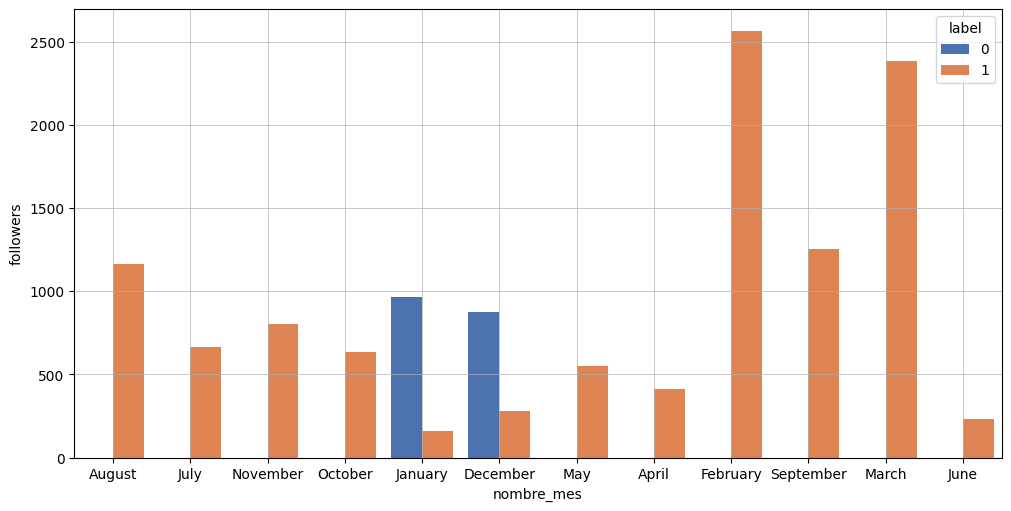

In [221]:
# Diagramas de barras combinados
tw_eda.plot_combined_bar(
                                layout = 'constrained',
                                fig_x_size = 10,
                                fig_cols = 1,
                                value_feature =  'followers',
                                target_feature = 'nombre_mes',
                                max_categories = 10,
                                divide_feature = "label",
                                errorbar = None,
                                estimator = np.mean, # Estimator puede ser un callable (es decir funcion) np.mean, np.sum o 'sum', ... funciones de numpy que se apliquen a un vector
                                                    # np.mean te hace la media de todo el vestor y te la plotea en el eje y
                                                    # np.sum te suma todo el vector y te lo plotea en el eje y
                                color = 0,
                                )

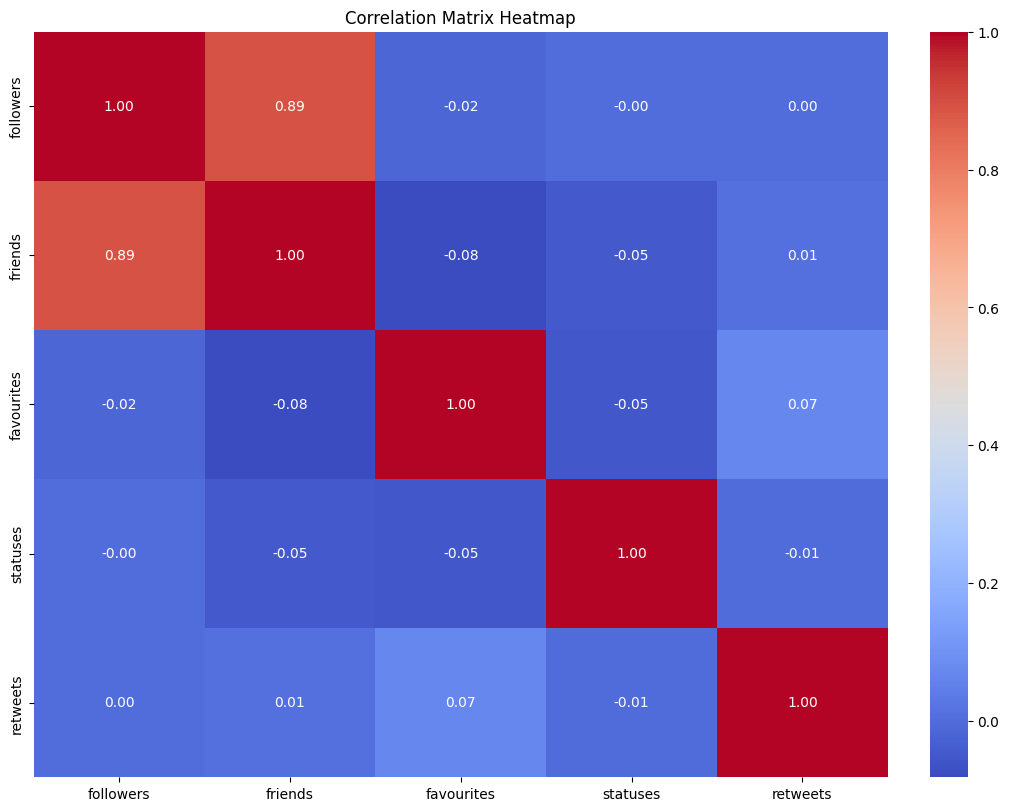

In [222]:
# mapa de calor de la matriz de correlacion (coeficientes de pearson entre cada par de features numericas)
tw_eda_std.plot_corr_heatmap(
                                fig_x_size = 10, 
                                fig_y_size = 8, 
                                layout = 'constrained' , 
                                linewidth = 0.5, 
                                cmap = 'coolwarm', # 'Set1', 'Set2', 'Set3', 'Paired','Accent', 'Prism', 'Dark2','Paired', 'coolwarm', 'viridis', 'cubehelix'
                                annot = True, # If True, plot el valor numerico de corrrelacion (entre variables) en la celda del mapa de calor
                                fmt = '.2f' # Especificacion del formato numerico
                                
                                )

#### **apenas hay correlacion, excepto por el numero de followers y el numero de friends que estan positivamente realcionadas, si una aumenta la otra tambien. Podria prescdindir de una de ellas para la prediccion**

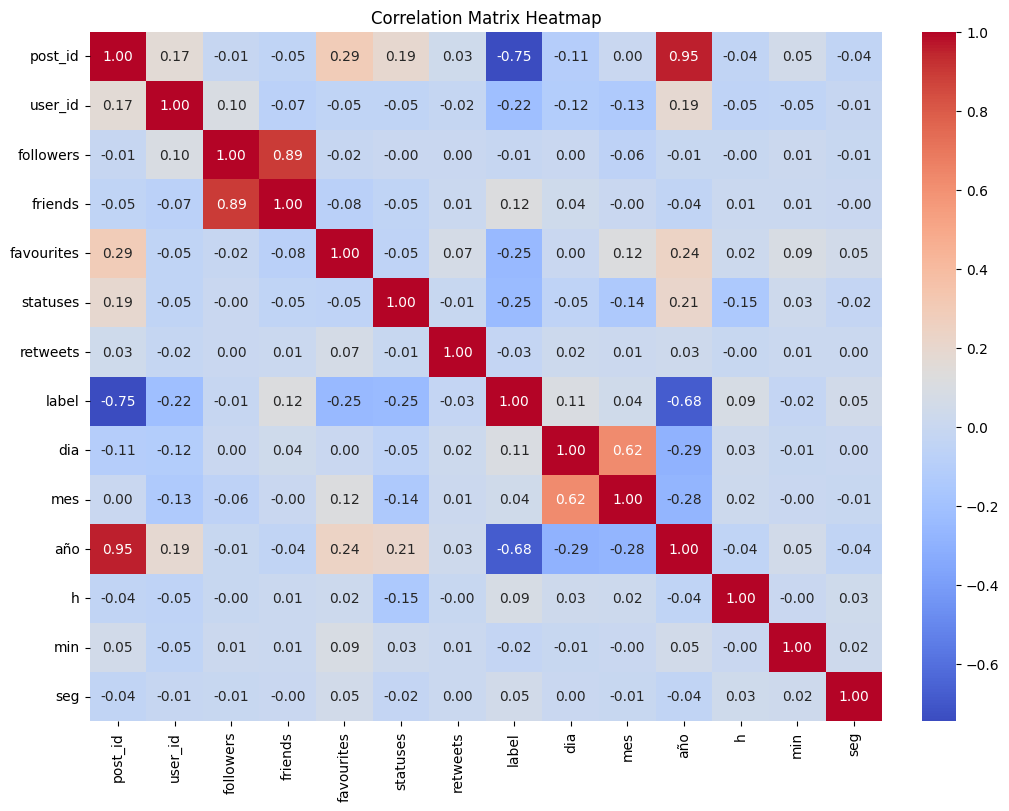

In [223]:
# mapa de calor de la matriz de correlacion (coeficientes de pearson entre cada par de features numericas)
tw_eda.plot_corr_heatmap(
                                fig_x_size = 10, 
                                fig_y_size = 8, 
                                layout = 'constrained' , 
                                linewidth = 0.5, 
                                cmap = 'coolwarm', # 'Set1', 'Set2', 'Set3', 'Paired','Accent', 'Prism', 'Dark2','Paired', 'coolwarm', 'viridis', 'cubehelix'
                                annot = True, # If True, plot el valor numerico de corrrelacion (entre variables) en la celda del mapa de calor
                                fmt = '.2f' # Especificacion del formato numerico
                                
                                )

#### **en el caso del dataset sin estandarizar ni dropear columnas, la variable target esta negativamente relacionada con el id del tweet, los tweets clasificados como 1 tendran menores valores del id del post**

In [ ]:
# Scatter plot contra labels
tw_eda_std.plot_scatter(
                            fig_x_size = 14, 
                            fig_cols = 2,
                            linewidth =  0.5,  
                            layout = 'constrained' , 
                            x =   ['followers','friends', 'favourites', 'statuses', 'retweets'], 
                            y = ["friends"], 
                            size = "retweets", 
                            hue = "favourites", 
                            color = 0, 
                            plotting_lib = 'plotly', 
                            umbral = 5, 
                            show_outliers = False, 
                            plotly_opacity = 0.6,
                            plotly_colorscale = 20, #[19,20,21,22,23,24]
                            plotly_bgcolor = None ,# str or none
                            save_figure = None, #["jpeg","png","WebP",None]
                            name_figure = "Fig"  
                            )

## Preprocesamiento

In [226]:
tw_eda.data.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes',
       'año', 'h', 'min', 'seg', 'dia_semana', 'nombre_mes'],
      dtype='object')

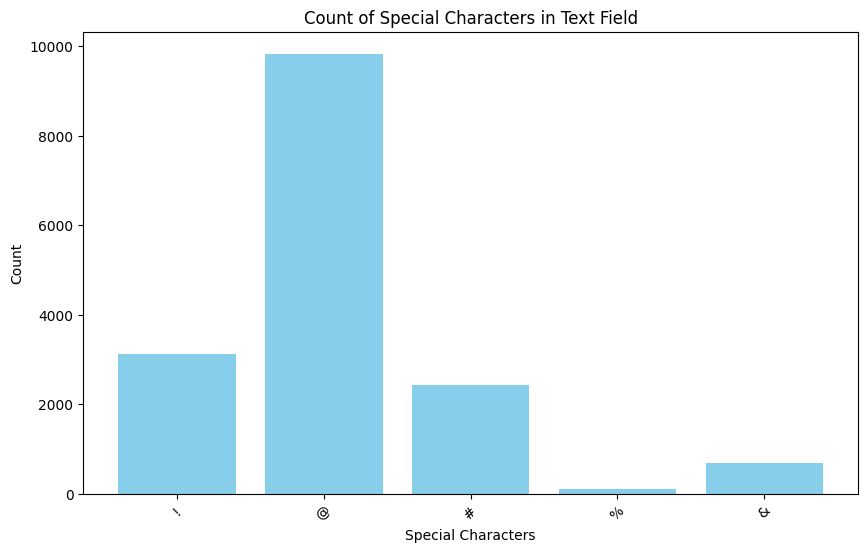

0        It's just over 2 years since I was diagnosed w...
1        It's Sunday, I need a break, so I'm planning t...
2        Awake but tired. I need to sleep but my brain ...
3        RT @SewHQ: #Retro bears make perfect gifts and...
4        It’s hard to say whether packing lists are mak...
                               ...                        
19995                A day without sunshine is like night.
19996    Boren's Laws: (1) When in charge, ponder. (2) ...
19997    The flow chart is a most thoroughly oversold p...
19998    Ships are safe in harbor, but they were never ...
19999       Black holes are where God is dividing by zero.
Name: post_text, Length: 20000, dtype: object


In [235]:
def count_special_caracters(special_c : List[str], data : pd.DataFrame, text_field_name :str, delete :bool =False, plot : bool =False):
    df = data.copy()
    special_c_count = {}
    count = 0
    for c in special_c:
        count = 0
        for i in range(df.shape[0]):
            if c in df.loc[i,text_field_name]:
                count += 1
                if delete:
                    text = df.loc[i,text_field_name]
                    clean_text = text.replace(c,'')
                    clean_text = df.loc[i,text_field_name]
            special_c_count[c] = count
    if plot:
        plt.figure(figsize=(10, 6))
        plt.bar(special_c_count.keys(), special_c_count.values(), color='skyblue')
        plt.xlabel('Special Characters')
        plt.ylabel('Count')
        plt.title('Count of Special Characters in Text Field')
        plt.xticks(rotation=45)
        plt.show()

    return special_c_count

# Example usage
#data = {
#    'TextField': ["Hello, world!", "Python@3.8", "Good#Morning!", "Welcome%to&Pandas"]
#}
#
#df = pd.DataFrame(data)
#
#special_characters = ['!', '@', '#', '%', '&']

special_c = count_special_caracters(special_characters, tw_eda.data, 'post_text', delete=False, plot=True)

print( tw_eda.data["post_text"])
                
        

## Creacion dataset de entrenamiento [HG Dataset]

In [154]:
# util functions
def get_current_utc_date_iso():
    # Get the current date and time in UTC and format it directly
    return datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S")

In [155]:
class TwDataset:
  def __init__(self, tokenizer,df, text_field_name, label_field_name, id_field_name):
    self.tokenizer = tokenizer
    self.data = df
    try:
      self.labels = df[label_field_name].unique()
    except Exception as e:
      print(e)
    self.label2id = {l:i for i,l in enumerate(self.labels)}
    self.id2label = {i:l for i,l in enumerate(self.labels)}
    self.text_f_name = text_field_name
    self.label_f_name = label_field_name
    if id_field_name:
      self.id_field_name = id_field_name
      self.ids = {k:[] for k in id_field_name}
      print('ID FIELDS :',self.ids)
    self.tokens = []
    self.len_texts = []


  def _tokenize_texts(self, texts : List[str], tensor :bool = False):
    if isinstance(texts , list):
      if self.tokenizer is not None:
        if tensor:
          x = self.tokenizer(texts, padding=True, truncation=True,  return_tensors="pt")
        else:
          x = self.tokenizer(texts, padding=True, truncation=True)
        return x
      else:
        raise ValueError('No tokenizer passed as argument')


  def _process_dataset(self, dataset) -> dict:
      text_name_field = self.text_f_name if isinstance(self.text_f_name, str) else None
      if text_name_field is None:
          raise AttributeError("Text field name must be str")

      text = str(dataset[text_name_field]) # aseguramos tipo de dato es str

      # tokenizacion
      #tokenized = self.tokenizer(text, padding=True, truncation=True, ,max_lenght =512 )
      tokenized = self.tokenizer(text,truncation=True )

      # calculo de tokens , caracteres y ids por texto
      self.tokens.append(len(tokenized["input_ids"]))
      self.len_texts.append(len(text))
      for id_i in self.ids.keys():
        self.ids[id_i].append(dataset[id_i])

      # labels
      tokenized["labels"] = dataset[self.label_f_name]

      return tokenized


  def get_hg_dataset(self, split : bool = False, tokenize :bool = True, from_csv: bool =False, csv_path :str = None ):

      # load original dataset from path
      if from_csv:
        try:
          dataset = load_dataset("csv", data_files=csv_path, split = 'train')
          try:
            dataset = dataset.remove_columns(["Unnamed: 0"])
          except:
            pass
          print(dataset)
        except Exception as e:
            print(e)
        if split:
          dataset_train_test = dataset.train_test_split(test_size = 0.2, shuffle = True, seed =42)
          dataset_train_val = dataset_train_test["train"].train_test_split(test_size = 0.1, shuffle = True, seed =42)
          dataset = DatasetDict({
                                                  "train": dataset_train_val["train"],
                                                  "validation": dataset_train_val["test"],
                                                  "test":dataset_train_test["test"]
                                                  })
      else:
        try:
            if split:
                # test 20 % train
                df_train_val, df_test = train_test_split(self.data, test_size=0.2, random_state=42)
                print('\n---------------------------------------------------')
                print("Test df shape : ", df_test.shape)
                # Validation 10% de train
                df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42)
                print("Train df shape : ", df_train.shape)
                print("validation df shape : ", df_val.shape)
                print('---------------------------------------------------\n')


                dataset = DatasetDict({
                                                    "train": ds.from_pandas(df_train),
                                                    "validation": ds.from_pandas(df_val),
                                                    "test":ds.from_pandas(df_test)
                                                    })
            else:
                dataset = DatasetDict({
                                    "train": ds.from_pandas(self.data)
                                    })

            dataset = dataset.remove_columns(["Unnamed: 0"])
            print("\nHG DATASET :\n ", dataset)
            #dataset = load_dataset(self.path).remove_columns(["Unnamed: 0"])
        except Exception as e:
            print(e)


      if tokenize:
          dataset_tokenize = dataset.map(self._process_dataset, batched=False, remove_columns=self.data.columns.tolist())
      else:
          dataset_tokenize = None
      print("\nHG DATASET TOKENIZE:\n ", dataset_tokenize)
      return dataset,dataset_tokenize

  def get_plots(self, dir_path: str, figure_name: str, show : bool = False):

      def addlabels(x, y, text, size, rotation):
          colors = ['g', 'r', 'c', 'm', 'y', 'k']  # Removed 'b' (blue) from the list
          c = 0
          for i in range(len(x)):
              if c >= len(colors):
                  c = 0
              plt.annotate(text[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center', size=size, color=colors[c], rotation=rotation)
              c += 1

      # Calculate the number of tokens for each document
      if self.tokens and self.len_texts:

          # Plotting the histogram of token counts
          plt.figure(figsize=(10, 6))
          plt.hist(self.tokens, bins=30, color="blue", edgecolor="black", alpha=0.7)
          plt.title("Histogram of Token Counts")
          plt.xlabel("Token Count")
          plt.ylabel("Frequency")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "token_hist.png")
            plt.savefig(plot_file)
            plt.close()

          # Plotting the histogram of characters counts
          plt.figure(figsize=(10, 6))
          plt.hist(self.len_texts, bins=30, color="red", edgecolor="black", alpha=0.7)
          plt.title("Histogram of Character Counts")
          plt.xlabel("Character Count")
          plt.ylabel("Frequency")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "character_hist.png")
            plt.savefig(plot_file)
            plt.close()

          # Plotting ordered chunk vs num tokens
          SAMPLE_PLOT_SIZE = min(100, len(self.len_texts))
          NUM_CHUNKS = np.arange(SAMPLE_PLOT_SIZE)

          plt.figure(figsize=(10, 6))
          plt.bar(NUM_CHUNKS, self.tokens[:SAMPLE_PLOT_SIZE], color="blue", alpha=1)
          addlabels(NUM_CHUNKS, self.tokens[:SAMPLE_PLOT_SIZE], [str(t) for t in self.tokens[:SAMPLE_PLOT_SIZE]], 10, 0)
          for i,id_i in enumerate(self.id_field_name):
              plot_id = []
              for v in self.ids[id_i][:SAMPLE_PLOT_SIZE]:
                  plot_id.append('#'+ str(id_i)+':'+str(v))
              addlabels(
                          x = NUM_CHUNKS,
                          y = np.full(len(self.tokens[:SAMPLE_PLOT_SIZE]), np.max(self.tokens[:SAMPLE_PLOT_SIZE]))*(0.1*(i+1)),
                          text = plot_id,
                          size = 6,
                          rotation = 40)
          plt.title("Token counts per chunk index")
          plt.xlabel("CHUNK index")
          plt.ylabel("Token counts")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "num_token_per_chunk.png")
            plt.savefig(plot_file)
            plt.close()

          plt.figure(figsize=(10, 6))
          plt.bar(NUM_CHUNKS, self.len_texts[:SAMPLE_PLOT_SIZE], color="red", alpha=1)
          addlabels(NUM_CHUNKS, self.len_texts[:SAMPLE_PLOT_SIZE], [str(t) for t in self.len_texts[:SAMPLE_PLOT_SIZE]], 10, 0)
          for i,id_i in enumerate(self.id_field_name):
              plot_id = []
              for v in self.ids[id_i][:SAMPLE_PLOT_SIZE]:
                  plot_id.append('#'+ str(id_i)+':'+str(v))
              addlabels(
                          x = NUM_CHUNKS,
                          y = np.full(len(self.len_texts[:SAMPLE_PLOT_SIZE]), np.max(self.tokens[:SAMPLE_PLOT_SIZE]))*(0.2*(i+1)),
                          text = plot_id,
                          size = 6,
                          rotation = 40)
          plt.title("Character counts per chunk index")
          plt.xlabel("CHUNK index")
          plt.ylabel("Character counts")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "num_character_per_chunk.png")
            plt.savefig(plot_file)
            plt.close()


In [156]:
# MODEL
from transformers import AutoModel, AutoModel, AutoConfig
MODEL_NAME = 'microsoft/deberta-v3-base'
model = AutoModel.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

  0%|          | 0/1800 [1:13:35<?, ?it/s]
c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [157]:
config

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.41.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [158]:
tokenizer

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [159]:
dataset = TwDataset(
                    tokenizer =tokenizer ,
                    df = df,
                    text_field_name = 'post_text',
                    label_field_name = 'label',
                    id_field_name = ['post_id']
                    )
_, dataset_split = dataset.get_hg_dataset(split = True, tokenize = True, from_csv = True, csv_path = './data/data_tw.csv' )

ID FIELDS : {'post_id': []}
Dataset({
    features: ['post_id', 'post_created', 'post_text', 'user_id', 'followers', 'friends', 'favourites', 'statuses', 'retweets', 'label'],
    num_rows: 20000
})


Map: 100%|██████████| 4000/4000 [00:00<00:00, 4019.98 examples/s]


HG DATASET TOKENIZE:
  DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14400
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4000
    })
})


In [160]:
dataset_split["train"]["labels"][0:10]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

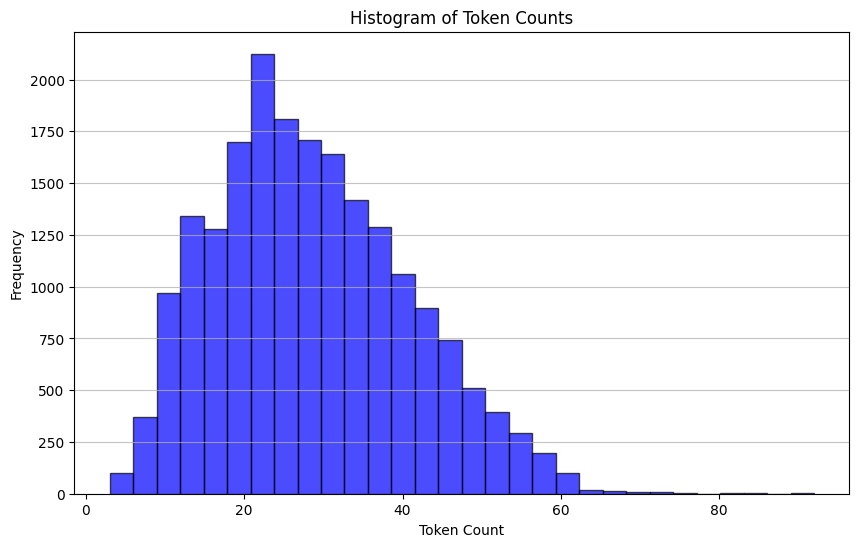

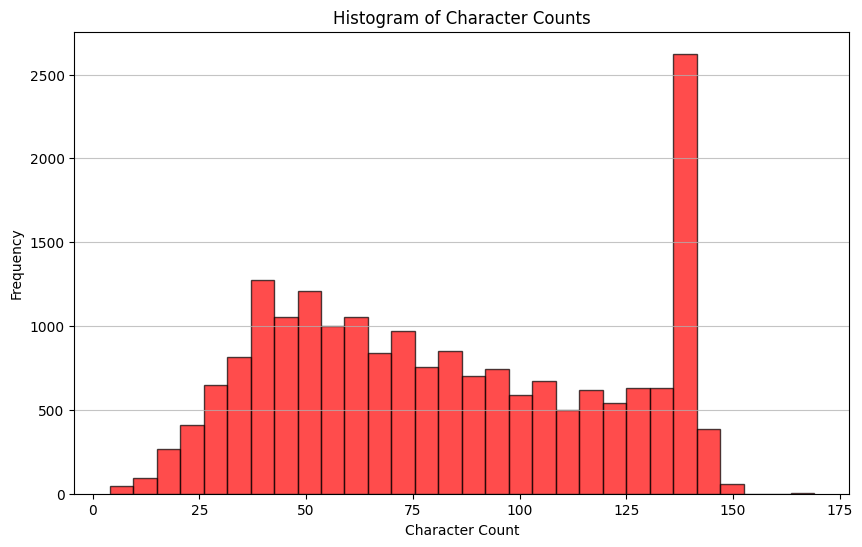

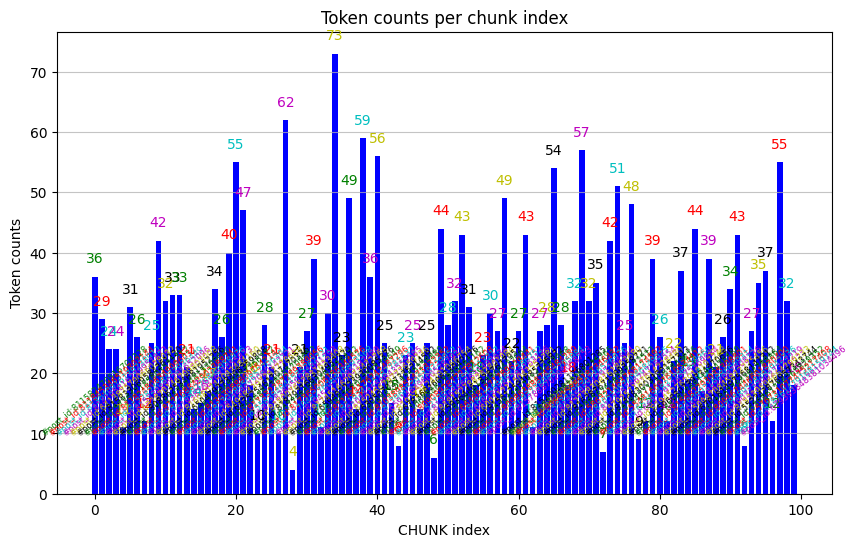

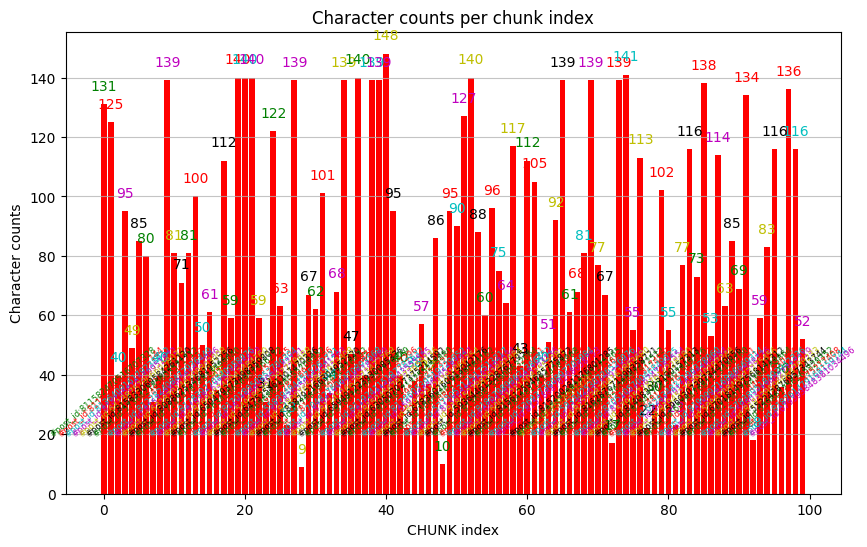

In [161]:
dataset.get_plots(dir_path = '/content/drive/MyDrive/NLP/data', figure_name = 'tw_fig', show = True)

### Clasifier class

#### Configuration for the classifier

In [182]:
FILE_PATH_CONF = './conf/model.json'
MODEL_CONFG ={
  "model": {
              "name": MODEL_NAME
          },
  "problem" : {
                "labels_to_pred" : [0,1]
  },
  "trainer":{
              "callbacks":{
                            "EarlyStoppingCallback": {
                                                        "early_stopping_patience":3,
                                                        "early_stopping_threshold":0.0
                                                      }
                          }
              },

  "metrics": {
              "type":
                    {
                    "f1": {"compute": True, "method": ["micro", "macro", "weighted","binary"]},
                    "recall": {"compute": True, "method": ["micro", "macro", "weighted","binary"]},
                    "MulticlassAccuracy": {"compute": True, "method": ["micro", "macro", "None"]},
                    "precision":{"compute": True, "method": ["micro", "macro", "weighted","binary"]}
                    },
                "optimize": {"name":"f1_macro"}
              },
  "training_args": {
                    "dir_path" : "./model/checkpoint",
                    "eval_strategy" : "steps",
                    "report_to":"tensorboard",
                    "save_strategy" : "epoch",
                    "learning_rate":3e-05,
                    "per_device_train_batch_size":1,
                    "per_device_eval_batch_size":1,
                    "num_train_epochs":10,
                    "weight_decay":0.01,
                    "warmup_steps":2,
                    "adam_epsilon":1e-08,
                    "load_best_model_at_end":True,
                    "metric_for_best_model":"f1_macro",
                    "gradient_accumulation_steps": 1,
                    "warmup_ratio":0.03,
                    "fp16_full_eval":False,
                    "fp16":False,
                    "bf16":True 
                  }
}

with open(FILE_PATH_CONF, "w") as outfile:
    json.dump(MODEL_CONFG, outfile)

In [183]:
# MODULE CLASS DOCU:
"""nn.Module :
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:
self.sub_module = nn.Linear(...)"""

os.environ['HF_TOKEN'] = 'ls__fe633ef5a71843baa5d07db00d83cd68'

# Util functions
def get_current_utc_date_iso():
    return datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S")

class BertNet:

    def __init__(self, model_conf_path: str):
        self.config_path = model_conf_path
        self.config = self._parse_config()
        self.model_name = self._get_model_name()
        self.model_tokenizer = self._get_tokenizer()
        self.model_config = self._get_model_config()
        self.model = self._get_model()
        self.compute_metric_f = self._get_metrics()
        self.train_args = self._get_training_args()

    def _parse_config(self) -> Dict:
        if not os.path.exists(self.config_path):
            raise FileNotFoundError(f"Config file not found at {self.config_path}")
        with open(self.config_path, 'r') as file:
            config = json.load(file)
        return config

    def _get_model_name(self):
        model = self.config.get("model", {})
        model_name = model.get("name", None)
        if model_name is None:
            raise ValueError("Model name not defined in the model config file")
        return model_name

    def _get_model_config(self):
        problem = self.config.get("problem", {})
        self.labels = problem.get("labels_to_pred", None)
        if self.labels is None:
            raise ValueError("Labels to predict not defined in the model config file")
        self.id2label = {i: lab for i, lab in enumerate(self.labels)}
        self.label2id = {lab: i for i, lab in enumerate(self.labels)}
        try:
            return AutoConfig.from_pretrained(
                pretrained_model_name_or_path=self.model_name,
                num_labels=len(self.labels),
                id2label=self.id2label,
                label2id=self.label2id
            )
        except Exception as e:
            raise ValueError(f"Error in get Config Model method: {e}")

    def _get_model(self):
        try:
            return AutoModelForSequenceClassification.from_pretrained(self.model_name, config=self.model_config)
        except Exception as e:
            raise ValueError(f"Error in get Model method: {e}")

    def _get_tokenizer(self):
        try:
            return AutoTokenizer.from_pretrained(self.model_name)
        except Exception as e:
            raise ValueError(f"Error in get tokenizer method: {e}")

    def _get_metrics(self):
        metrics = self.config.get("metrics", {})
        self.metrics_to_compute = {metric: details["method"] for metric, details in metrics["type"].items() if details["compute"]}
        self.opt_metric = metrics.get("optimize", "")
        return self._get_compute_metric_f(metrics=self.metrics_to_compute)

    def _get_compute_metric_f(self, metrics: Dict[str, List[str]]):
        master_metric_mapper = {
            "f1_macro": f1_score,
            "f1_weighted": f1_score,
            "f1_binary": f1_score,
            "MulticlassAccuracy_micro": MulticlassAccuracy(average='micro', num_classes=4, k=1),
            "MulticlassAccuracy_macro": MulticlassAccuracy(average='macro', num_classes=4, k=1),
            "MulticlassAccuracy_None": MulticlassAccuracy(average=None, num_classes=4, k=1),
            "recall_micro": recall_score,
            "recall_macro": recall_score,
            "recall_weighted": recall_score,
            "recall_binary": recall_score,
            "precision_micro": precision_score,
            "precision_macro": precision_score,
            "precision_weighted": precision_score,
            "precision_binary": precision_score
        }
        self._metric_obj = {}
        for metric, methods in metrics.items():
            for method in methods:
                key_name = metric + "_" + method
                metric_obj = master_metric_mapper.get(key_name, None)
                if metric_obj is not None:
                    self._metric_obj[key_name] = metric_obj

        def compute_metrics(pred: EvalPrediction):
            predictions, labels = pred
            predictions = torch.tensor(predictions)
            labels = torch.tensor(labels)

            pred_label = torch.argmax(predictions, dim=1)
            true_label = torch.argmax(labels, dim=1)

            metric_results = {}
            for m_name, metric in self._metric_obj.items():
                metric_name, method = m_name.rsplit('_', 1)
                if metric_name in ["f1", "precision", "recall"]:
                    metric_results[m_name] = metric(y_true=true_label, y_pred=pred_label, average=method)
                elif metric_name == "MulticlassAccuracy":
                    metric.update(pred_label, true_label)
                    metric_results[m_name] = metric.compute()

            cross_entropy_loss_f = nn.CrossEntropyLoss()
            loss = cross_entropy_loss_f(predictions, labels)
            metric_results["Train Cross entropy loss"] = loss.item()
            metric_results["Inverse Train Cross entropy loss"] = 1 / loss.item()

            return metric_results
        return compute_metrics

    def _get_training_args(self):
        training_args = self.config.get("training_args", {})
        return TrainingArguments(
            training_args.get("dir_path", "./MODEL/DEFAULT"),
            evaluation_strategy=training_args.get("evaluation_strategy", "epoch"),
            report_to=training_args.get("report_to", "tensorboard"),
            save_strategy=training_args.get("save_strategy", "epoch"),
            learning_rate=training_args.get("learning_rate", 3e-05),
            per_device_train_batch_size=training_args.get("per_device_train_batch_size", 20),
            per_device_eval_batch_size=training_args.get("per_device_eval_batch_size", 32),
            num_train_epochs=training_args.get("num_train_epochs", 3),  # Ajustado para tiempos de prueba
            weight_decay=training_args.get("weight_decay", 0.01),
            warmup_steps=training_args.get("weight_decay", 0.01),
            adam_epsilon=training_args.get("warmup_steps", 100),
            load_best_model_at_end=training_args.get("load_best_model_at_end", True),
            metric_for_best_model=training_args.get("metric_for_best_model", self.opt_metric),
            gradient_accumulation_steps=training_args.get("gradient_accumulation_steps", 10),
            warmup_ratio=training_args.get("warmup_ratio", 0.03),
            fp16_full_eval=training_args.get("fp16_full_eval", False),
            fp16=training_args.get("fp16", True),
            bf16=training_args.get("bf16", False)
        )
    def _get_data_collator(self):
        return DataCollatorWithPadding(tokenizer=self.model_tokenizer)

    def _get_trainer(self, dataset: DatasetDict):
        trainer_config = self.config.get("trainer", {})
        callbacks_args = trainer_config.get("callbacks", {})
        early_stopping_args = callbacks_args.get("EarlyStoppingCallback", {})
        self.data_collator = self._get_data_collator()
        return Trainer(
            model=self.model,
            args=self.train_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["validation"],
            tokenizer=self.model_tokenizer,
            compute_metrics=self.compute_metric_f,
            data_collator =  self.data_collator,
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=early_stopping_args.get("early_stopping_patience", 3),
                    early_stopping_threshold=early_stopping_args.get("early_stopping_threshold", 0.0)
                ),
                TensorBoardCallback()
            ]
        )

    def trainer(self, dataset: DatasetDict):
        self.trainer = self._get_trainer(dataset)
        return self.trainer


In [184]:
torch.cuda.empty_cache()

In [185]:
tw_bert = BertNet(FILE_PATH_CONF)
trainer = tw_bert.trainer(dataset_split)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 376.00 MiB. GPU 

In [169]:
torch.cuda.empty_cache()

In [170]:
trainer.train()

  0%|          | 0/9000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
results = trainer.evaluate(dataset_split["test"])
print(results)